# TODO
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another, create_icon_from_slide_general_path
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v011_hsk3_v1 import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [ ]:
truly_load_data = False
to_delete = True

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'hsk3_v1',
 'different_file_name': 'static/hsk/HSK3_sent_cat.csv',
 'custom_filters': [{'col_name': 'index', 'val': 0, 'operator_str': '>='},
  {'col_name': 'index', 'val': 9999, 'operator_str': '<='}],
 'sort_keys': ['category', 'index'],
 'sort_asc': [True, True],
 'voice_name_zh': 'zh-CN-XiaoyuMultilingualNeural',
 'voice_name_en': 'en-US-AvaMultilingualNeural',
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_combo_quality': 6,
 'categories_allowed': None,
 'categories2_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_st

# 1. Load data

In [6]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

1002_ec_csent_hsk3_v1 966


,index,chinese,trad,hsk3.0_pinyin,hsk3.0_def,video_notes,pinyin,english,sentence,sentence_pinyin,sentence_english,category
0,67,才能,才能,cáinéng,"ability, talent","HSK3.0 definition: ability, talent",cái néng,ability talent,只有努力才能成功。,zhǐ yǒu nǔ lì cái néng chéng gōng.,Only through hard work can you succeed.,Abilities & Skills
1,215,敢,敢,gǎn,"dare, make bold, have courage to, be sure, hav...","HSK3.0 definition: dare, make bold, have coura...",gǎn,dare,他敢独自旅行。,tā gǎn dú zì lǚ xíng.,He dares to travel alone.,Abilities & Skills
2,505,能力,能力,nénglì,"department, potency, ability, acquisition, acq...","HSK3.0 definition: department, potency, abilit...",néng lì,ability,她有很强的学习能力。,tā yǒu hěn qiáng de xué xí néng lì.,She has strong learning ability.,Abilities & Skills


# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 才能
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, ability talent
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 只有努力才能成功。
0.0s, row1
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 敢
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, dare
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 他敢独自旅行。
0.0s, row2
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 能力
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, ability
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 她有很强的学习能力。
0.0s, row3
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 听力
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, listening ability
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 学习语言时听力很重要
0.0s, row4
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 成功
0.000s, ALREADY EXISTS, en-US-AvaMultilingualNeural, success
0.000s, ALREADY EXISTS, zh-CN-XiaoyuMultilingualNeural, 努力是成功的关键。
0.

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.32 seconds, recid1002_ec_csent_hsk3_v1, row 0, 才能
0.27 seconds, recid1002_ec_csent_hsk3_v1, row 1, 敢
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 2, 能力
0.29 seconds, recid1002_ec_csent_hsk3_v1, row 3, 听力
0.29 seconds, recid1002_ec_csent_hsk3_v1, row 4, 成功
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 5, 成果
0.29 seconds, recid1002_ec_csent_hsk3_v1, row 6, 成就
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 7, 得分
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 8, 金牌
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 9, 决赛
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 10, 胜
0.27 seconds, recid1002_ec_csent_hsk3_v1, row 11, 胜利
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 12, 银牌
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 13, 按
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 14, 把握
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 15, 搬
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 16, 搬家
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 17, 办理
0.28 seconds, recid1002_ec_csent_hsk3_v1, row 18, 保持
0.29 se

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,才能,cái néng,ability talent,只有努力才能成功。,zhǐ yǒu nǔ lì cái néng chéng gōng.,Only through hard work can you succeed.,1.416,1.032,2.064,0,1.916,3.448,6.512,6.511667,"HSK3.0 definition: ability, talent",None,None,None
1,敢,gǎn,dare,他敢独自旅行。,tā gǎn dú zì lǚ xíng.,He dares to travel alone.,1.008,0.912,1.704,0,1.508,2.920,5.624,5.623667,"HSK3.0 definition: dare, make bold, have coura...",None,None,None
2,能力,néng lì,ability,她有很强的学习能力。,tā yǒu hěn qiáng de xué xí néng lì.,She has strong learning ability.,1.080,0.984,2.136,0,1.580,3.064,6.200,6.199667,"HSK3.0 definition: department, potency, abilit...",None,None,None


In [14]:
df_vocab_lists.head(20)

,index,chinese,trad,hsk3.0_pinyin,hsk3.0_def,video_notes,pinyin,english,sentence,sentence_pinyin,sentence_english,category
0,67,才能,才能,cáinéng,"ability, talent","HSK3.0 definition: ability, talent",cái néng,ability talent,只有努力才能成功。,zhǐ yǒu nǔ lì cái néng chéng gōng.,Only through hard work can you succeed.,Abilities & Skills
1,215,敢,敢,gǎn,"dare, make bold, have courage to, be sure, hav...","HSK3.0 definition: dare, make bold, have coura...",gǎn,dare,他敢独自旅行。,tā gǎn dú zì lǚ xíng.,He dares to travel alone.,Abilities & Skills
2,505,能力,能力,nénglì,"department, potency, ability, acquisition, acq...","HSK3.0 definition: department, potency, abilit...",néng lì,ability,她有很强的学习能力。,tā yǒu hěn qiáng de xué xí néng lì.,She has strong learning ability.,Abilities & Skills
3,709,听力,聽力,tīnglì,"hearing, listening ability","HSK3.0 definition: hearing, listening ability",tīng lì,listening ability,学习语言时听力很重要,xué xí yǔ yán shí tīng lì hěn zhòng yào,Listening is important when learning a language,Abilities & Skills
4,86,成功,成功,chénggōng,succeed,HSK3.0 definition: succeed,chéng gōng,success,努力是成功的关键。,nǔ lì shì chéng gōng de guān jiàn.,Hard work is the key to success.,Achievements & Results
5,87,成果,成果,chéngguǒ,"product, achievement, outcome, gain, productio...","HSK3.0 definition: product, achievement, outco...",chéng guǒ,achievement,他的研究取得了显著成果。,tā de yán jiū qǔ dé le xiǎn zhù chéng guǒ.,His research has achieved remarkable results.,Achievements & Results
6,88,成就,成就,chéngjiù,"achievement, accomplishment, success","HSK3.0 definition: achievement, accomplishment...",chéng jiù,accomplishment,他在工作中取得了很多成就。,tā zài gōng zuò zhōng qǔ dé le hěn duō chéng jiù.,He has achieved many accomplishments at work.,Achievements & Results
7,140,得分,得分,dé fēn,score,HSK3.0 definition: score,dé fēn,score,他在比赛中得分最高。,tā zài bǐ sài zhōng dé fēn zuì gāo.,He scored the highest in the game.,Achievements & Results
8,365,金牌,金牌,jīnpái,gold medal,HSK3.0 definition: gold medal,jīn pái,gold medal,他赢得了金牌。,tā yíng dé le jīn pái.,He won the gold medal.,Achievements & Results
9,397,决赛,決賽,juésài,"runoff, fight-off, cup_final, playoff, cup fin...","HSK3.0 definition: runoff, fight-off, cup_fina...",jué sài,final match,球队进入了决赛。,qiú duì jìn rù le jué sài.,The team entered the final match.,Achievements & Results


In [15]:
df_vocab_lists.tail(20)

,index,chinese,trad,hsk3.0_pinyin,hsk3.0_def,video_notes,pinyin,english,sentence,sentence_pinyin,sentence_english,category
946,900,直到,直到,zhídào,"until, up to","HSK3.0 definition: until, up to",zhí dào,until,他直到晚上才回家。,tā zhí dào wǎn shàng cái huí jiā.,He didn’t come home until evening.,Time & Frequency
947,912,至今,至今,zhìjīn,"thus_far, up_to_now, until_now, so far, to thi...","HSK3.0 definition: thus_far, up_to_now, until_...",zhì jīn,up to now,这件事至今没人知道。,zhè jiàn shì zhì jīn méi rén zhī dào.,Up to now no one knows about this.,Time & Frequency
948,922,终于,終於,zhōngyú,"in the last analysis, at long last, at last, l...","HSK3.0 definition: in the last analysis, at lo...",zhōng yú,finally,他终于完成了任务。,tā zhōng yú wán chéng le rèn wu.,He finally finished the task.,Time & Frequency
949,949,自从,自從,zìcóng,since,HSK3.0 definition: since,zì cóng,since,自从搬家后，他很少来这里。,zì cóng bān jiā hòu tā hěn shǎo lái zhè lǐ.,Since moving he seldom comes here.,Time & Frequency
950,958,总是,總是,zǒngshì,always,HSK3.0 definition: always,zǒng shì,always,他总是笑得很开心。,tā zǒng shì xiào de hěn kāi xīn.,He is always smiling happily.,Time & Frequency
951,75,厂,厰,chǎng,"factory, mill, plant, works, yard, depot","HSK3.0 definition: factory, mill, plant, works...",chǎng,factory,工厂生产汽车零件。,gōng chǎng shēng chǎn qì chē líng jiàn.,The factory produces car parts.,Work & Industry
952,112,创业,創業,chuàngyè,"start undertaking, do pioneering work","HSK3.0 definition: start undertaking, do pione...",chuàng yè,start a business,他计划明年创业。,tā jì huà míng nián chuàng yè.,He plans to start a business next year.,Work & Industry
953,115,从事,從事,cóngshì,"engross, have, join, treat, plow, handle, foll...","HSK3.0 definition: engross, have, join, treat,...",cóng shì,engage in,他从事教育工作。,tā cóng shì jiào yù gōng zuò.,He works in education.,Work & Industry
954,238,工业,工業,gōngyè,"industrial, industry","HSK3.0 definition: industrial, industry",gōng yè,industry,这个城市的工业很发达。,zhè gè chéng shì de gōng yè hěn fā dá.,The city's industry is very developed.,Work & Industry
955,239,工厂,工廠,gōngchǎng,"layout, mill, factory, remuneration, workshop,...","HSK3.0 definition: layout, mill, factory, remu...",gōng chǎng,factory,他们在工厂工作。,tā men zài gōng chǎng gōng zuò.,They work in the factory.,Work & Industry


# 4. Create non-vocab audio recordings

In [12]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head()

Generated 欢迎观看我的普通话数据库视频 11: HSK3级音频卡片
Generated 这些是将在接下来的103分钟内复习的966个单词
Generated 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 11: HSK3级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.910000,NaN,output/videos/1002_ec_csent_hsk3_v1/欢迎观看我的普通话数...,500,intro,6.910000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的103分钟内复习的966个单词,Zhèxiē shì jiàng zài jiē xiàlái de 103 fēnzhōn...,These are the 966 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.740000,NaN,output/videos/1002_ec_csent_hsk3_v1/这些是将在接下来的1...,500,word_list,13.650000,6.910000,NaN,NaN,NaN
2,才能,cái néng,ability talent,只有努力才能成功。,zhǐ yǒu nǔ lì cái néng chéng gōng.,Only through hard work can you succeed.,1.416,1.032,2.064,0.0,1.916,3.448,6.512,6.511667,"HSK3.0 definition: ability, talent",None,None,None,20.161667,13.650000,13.650000,15.566000,17.098000
3,敢,gǎn,dare,他敢独自旅行。,tā gǎn dú zì lǚ xíng.,He dares to travel alone.,1.008,0.912,1.704,0.0,1.508,2.920,5.624,5.623667,"HSK3.0 definition: dare, make bold, have coura...",None,None,None,25.785333,20.161667,20.161667,21.669667,23.081667
4,能力,néng lì,ability,她有很强的学习能力。,tā yǒu hěn qiáng de xué xí néng lì.,She has strong learning ability.,1.080,0.984,2.136,0.0,1.580,3.064,6.200,6.199667,"HSK3.0 definition: department, potency, abilit...",None,None,None,31.985000,25.785333,25.785333,27.365333,28.849333


# 5. Combine individual vocab into final audio recording

In [13]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

107.10s, output/videos/1002_ec_csent_hsk3_v1/audio.mp3


# 6. Create images for video

In [16]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

1002_ec_csent_hsk3_v1 loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,video_notes,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 11: HSK3级音频卡片,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.910000,NaN,output/videos/1002_ec_csent_hsk3_v1/欢迎观看我的普通话数...,500.0,intro,6.910000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的103分钟内复习的966个单词,Zhèxiē shì jiàng zài jiē xiàlái de 103 fēnzhōn...,These are the 966 words that will be reviewed ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.740000,NaN,output/videos/1002_ec_csent_hsk3_v1/这些是将在接下来的1...,500.0,word_list,13.650000,6.910000,NaN,NaN,NaN
2,才能,cái néng,ability talent,只有努力才能成功。,zhǐ yǒu nǔ lì cái néng chéng gōng.,Only through hard work can you succeed.,1.416,1.032,2.064,0.0,1.916,3.448,6.512,6.511667,"HSK3.0 definition: ability, talent",NaN,NaN,NaN,20.161667,13.650000,13.650000,15.566000,17.098000
3,敢,gǎn,dare,他敢独自旅行。,tā gǎn dú zì lǚ xíng.,He dares to travel alone.,1.008,0.912,1.704,0.0,1.508,2.920,5.624,5.623667,"HSK3.0 definition: dare, make bold, have coura...",NaN,NaN,NaN,25.785333,20.161667,20.161667,21.669667,23.081667
4,能力,néng lì,ability,她有很强的学习能力。,tā yǒu hěn qiáng de xué xí néng lì.,She has strong learning ability.,1.080,0.984,2.136,0.0,1.580,3.064,6.200,6.199667,"HSK3.0 definition: department, potency, abilit...",NaN,NaN,NaN,31.985000,25.785333,25.785333,27.365333,28.849333


## 6a. Vocab words

Drawing 0: 才能
Drawing 1: 敢
Drawing 2: 能力
reduced font size to 23
reduced font size to 22
reduced font size to 21
reduced font size to 20
reduced font size to 19
reduced font size to 18
reduced font size to 17
reduced font size to 16
reduced font size to 15
reduced font size to 14
reduced font size to 13
reduced font size to 12
Drawing 3: 听力
Drawing 4: 成功
Drawing 5: 成果
Drawing 6: 成就
Drawing 7: 得分
Drawing 8: 金牌
Drawing 9: 决赛
Drawing 10: 胜
Drawing 11: 胜利
Drawing 12: 银牌
Drawing 13: 按
Drawing 14: 把握
Drawing 15: 搬
Drawing 16: 搬家
Drawing 17: 办理
Drawing 18: 保持
Drawing 19: 保
Drawing 20: 保留
Drawing 21: 保证
Drawing 22: 保护
Drawing 23: 变为
Drawing 24: 表达
Drawing 25: 表明
reduced font size to 23
reduced font size to 22
reduced font size to 21
Drawing 26: 表现
Drawing 27: 补
Drawing 28: 补充
Drawing 29: 步
Drawing 30: 采取
Drawing 31: 采用
Drawing 32: 产生
Drawing 33: 吵
Drawing 34: 吵架
Drawing 35: 称为
Drawing 36: 成立
Drawing 37: 成长
Drawing 38: 充满
reduced font size to 23
reduced font size to 22
reduced font size to 21
r


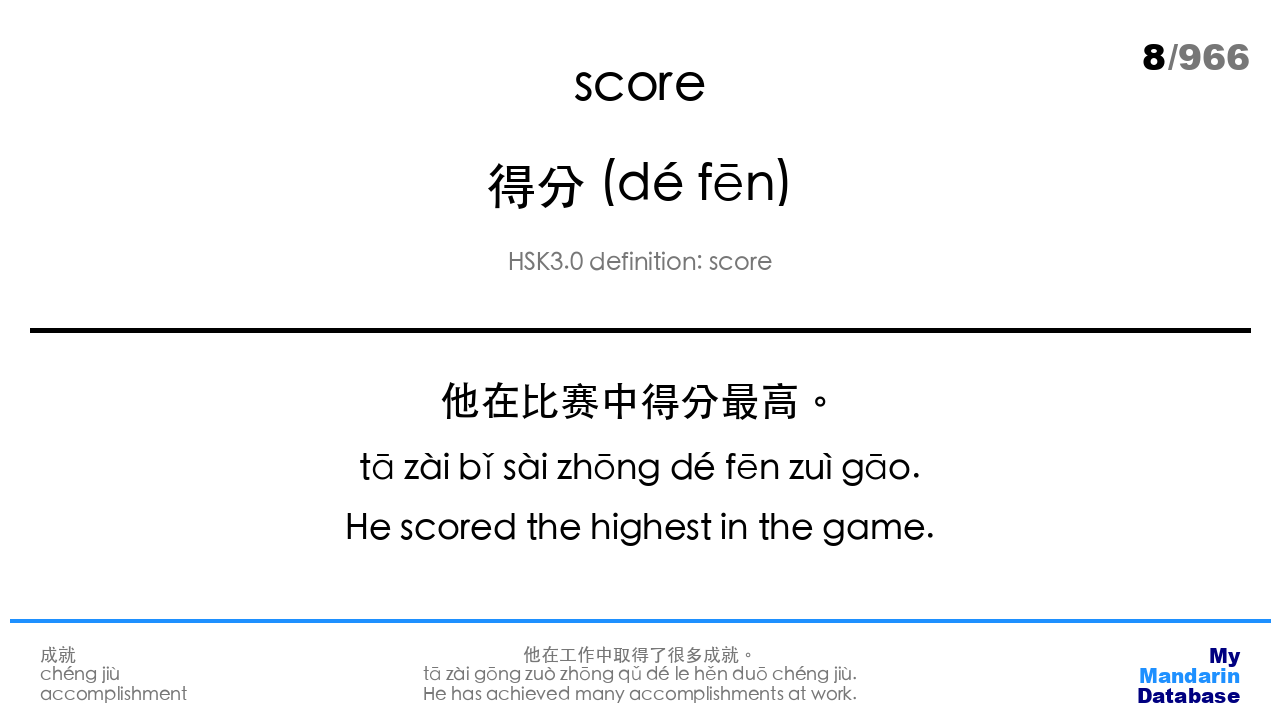

In [17]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


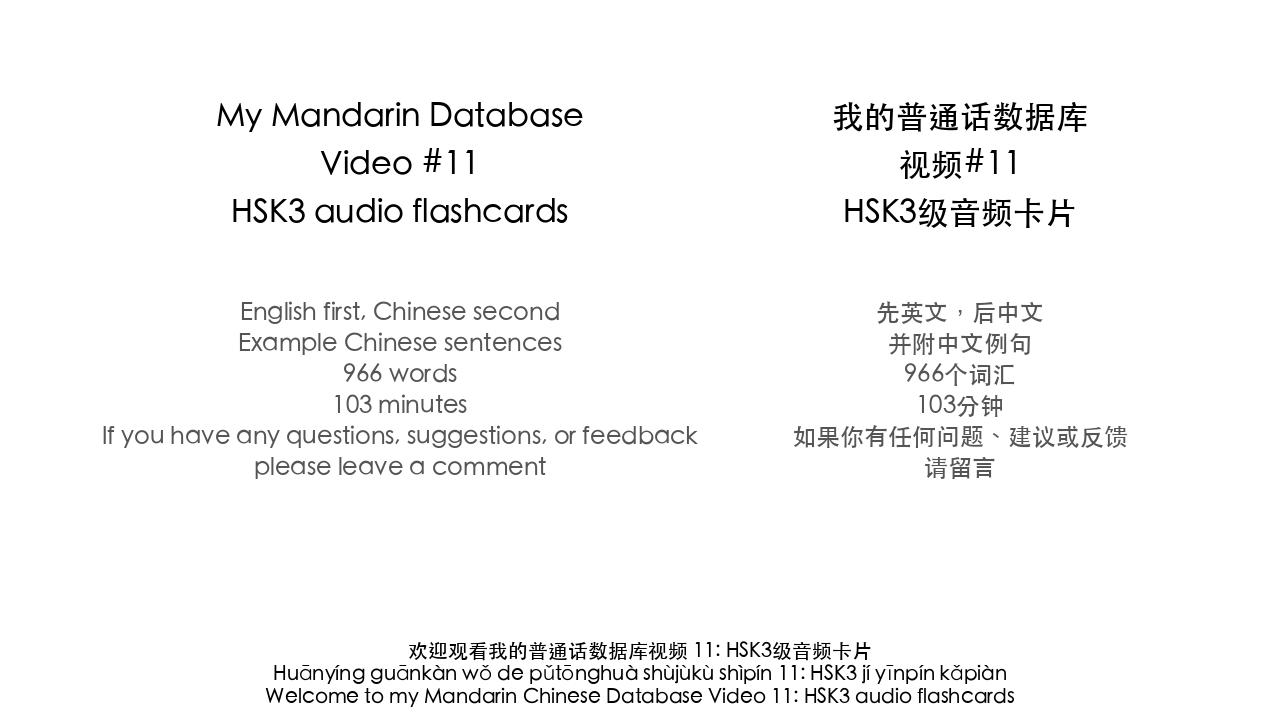

In [18]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced font size to 8
reduced font size to 7
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 5
reduced text to accomplishmen
reduced text to accomplishme
reduced text to accomplishm
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font size to 7
reduced font size to 6
reduced font size to 8
reduced font siz


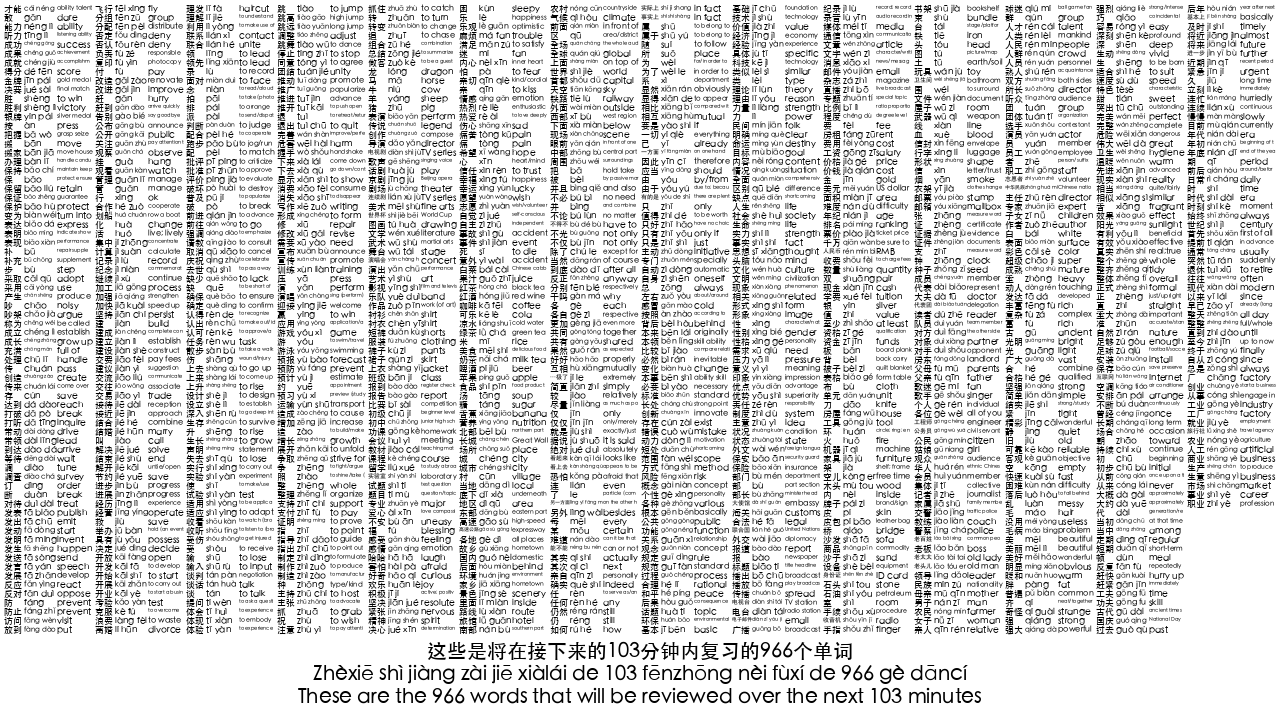

In [49]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

"cái néng" reduced font size to 7
"ability talent" reduced font size to 7
"ability talent" reduced font size to 5
"listening ability" reduced font size to 7
"listening ability" reduced font size to 5
"chéng gōng" reduced font size to 7
"chéng gōng" reduced font size to 5
"chéng guǒ" reduced font size to 7
"chéng guǒ" reduced font size to 5
"achievement" reduced font size to 7
"achievement" reduced font size to 5
"chéng jiù" reduced font size to 7
"accomplishment" reduced font size to 7
"accomplishment" reduced font size to 5
"accomplishment" reduced font size to 3
"gold medal" reduced font size to 7
"gold medal" reduced font size to 5
"final match" reduced font size to 7
"final match" reduced font size to 5
"silver medal" reduced font size to 7
"silver medal" reduced font size to 5
"grasp seize" reduced font size to 7
"grasp seize" reduced font size to 5
"move house" reduced font size to 7
"move house" reduced font size to 5
"handle conduct" reduced font size to 7
"handle conduct" redu


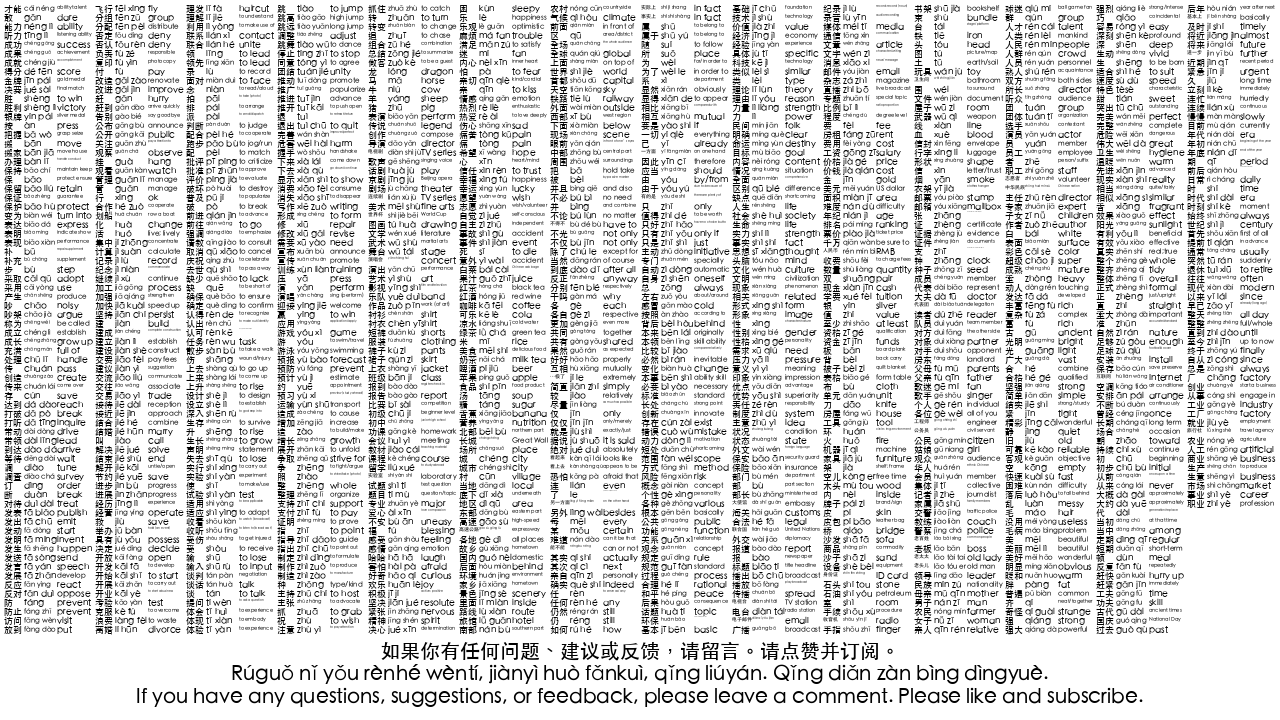

In [50]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


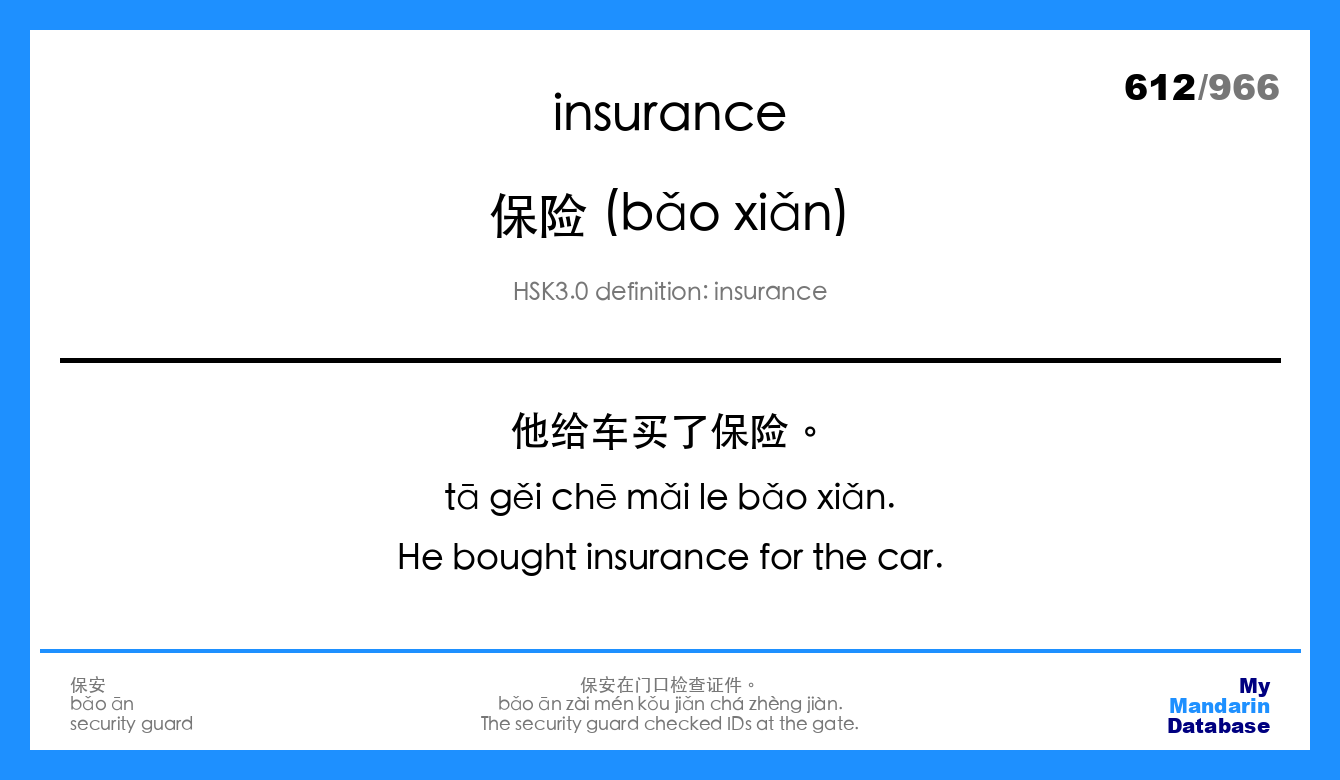

In [51]:
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()


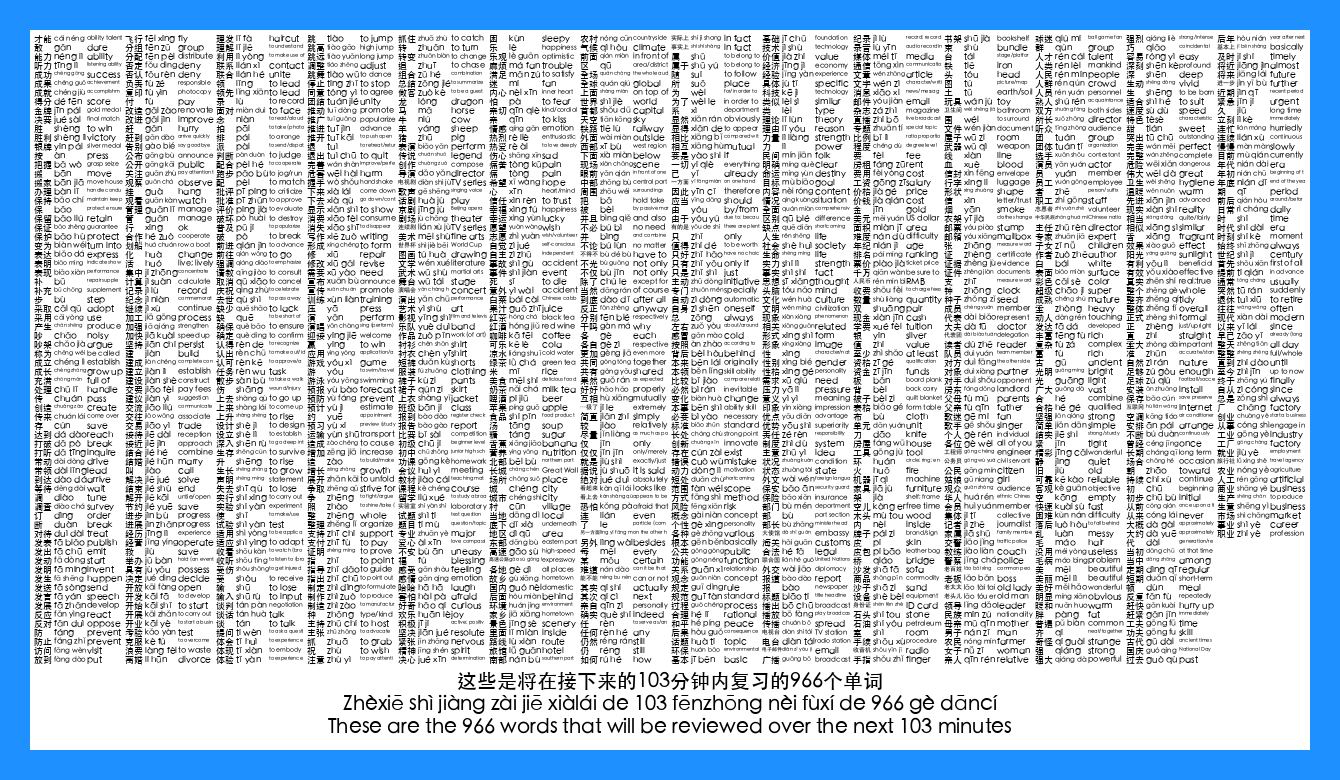

In [52]:
path_to_bottom_image = f"{project_artifacts_folder}/word_list.png"
img = create_icon_from_slide_general_path(icon_configs, video_configs, path_to_bottom_image)
img.save(f'{project_artifacts_folder}/icon2.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon2.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [29]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 2211
audio: 4614.410s, video: 4614.347s; difference: 0.063s
MoviePy - Building video output/videos/1001_ec_csent_hsk2_v1/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/1001_ec_csent_hsk2_v1/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/1001_ec_csent_hsk2_v1/video.mp4
